# Madaline

## Table of Contents
- [MRI and MRII Algorithms](#mri-and-mrii-algorithms)
- [Imports and Settings](#imports-and-settings)
- [Dataset](#dataset)
- [Scatter Plot](#scatter-plot)
- [Model Training](#model-training)
- [Analysis of the Results](#analysis-of-the-results)
- [References](#references)

The `Madaline` (Supervised Learning) or `Multiple Adaptive Linear Neuron` model consists of many `Adaline` in paraller with a single output unit. The Adaline layer is present between the input layer nad the Madaline layer hence Adaline layer is a hidden layer. The weights between the input layer and the hidden layer are adjusted, and the weight between the hidden layer and the output layer is fixed.

The functionality of hidden layer is as bellow:

$$ y = f(\sum_{i=1}^{n} w_i x_i + b) $$

\begin{equation}
f(x) = \begin{cases} 1 & \text{if } x \geq 0 \\ -1 & \text{if } x < 0 \end{cases}
\end{equation}


## MRI and MRII Algorithms


The **MRI** algorithm (Marginal Ranking Interpretation) is typically used for ranking tasks. It evaluates the importance of features by marginalizing over them and ranking their impact on predictive accuracy. It works well for feature ranking in models where interpretability of features is critical.

The **MRII** algorithm (Marginal Ranking Interpretation with Interaction) extends MRI by considering interactions between features, not just individual contributions. This method accounts for feature interactions, providing a more detailed view of feature importance and allowing more nuanced insights into model behavior.

## Imports and Settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from tqdm.notebook import tqdm

np.random.seed(42)

In [2]:
def plt_data_points(x, y):
    colors = ['purple', 'teal']
    markers = ("v", "o")
    for index, label in enumerate(np.unique(y)):
        plt.scatter(
            x=x[y == label, 0], y=x[y == label, 1],
            alpha=0.8, c=colors[index],
            marker=markers[index], label=label,
        )    

def plot_distribution(x, y, x_label='First Property', y_label='Second Property'):
    plt.figure(figsize=(5, 4))
    plt_data_points(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title('Distribution of Dataset')
    plt.legend(loc='upper right')
    plt.show()    

def calculate_decision_boundary(hidden_layer_baias, hidden_layer_weights):
    intercept = float(- hidden_layer_baias / hidden_layer_weights[1])
    slope = - hidden_layer_weights[0] / hidden_layer_weights[1]
    return intercept, slope

def plt_boundaries(classifier):
    for i in range(classifier.n_neurons):
        intercept, slope = calculate_decision_boundary(classifier.hidden_bias[i], classifier.hidden_weights[i])
        plt.axline((0, intercept), slope=slope, color = "black")    

def plt_set_lim(x):
    xlim_left = x[:, 0].min() - 1
    xlim_right = x[:, 0].max() + 1
    ylim_left = x[:, 1].min() - 1
    ylim_right = x[:, 1].max() + 1

    plt.xlim(xlim_left, xlim_right)
    plt.ylim(ylim_left, ylim_right)    

def plot_decision_regions(x, y, classifier, x_label='First Property', y_label='Second Property'):
    plt.figure(figsize=(5, 4))
    plt_boundaries(classifier)
    plt_set_lim(x)
    plt_data_points(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc="upper right")
    plt.show()

def accuracy_on(labels, outputs, title):
    acc = accuracy_score(labels, outputs)
    return [title, acc]

def log_accuracy(y_train, y_test, y_train_predicted, y_test_predicted):
    table = [
         accuracy_on(y_train, y_train_predicted, 'Train'),
         accuracy_on(y_test, y_test_predicted, 'Test')
    ]
    print(tabulate(table, headers=["Dataset", "Accuracy"], tablefmt="pretty"))

def plot_curve(data, title: str):
    scale_x = range(1, len(data) + 1)

    plt.figure(figsize=(10, 4))
    plt.plot(scale_x, data)
    plt.xlabel("Epochs")
    plt.ylabel("SSE (Sum Squared Error)")
    plt.title(title)
    plt.show()

In [ ]:
class Madeline:
    def __init__(self, n_neurons, lr=0.01, n_epochs=100):
        self.n_neurons = n_neurons
        self.lr = lr
        self.n_epochs = n_epochs

        self.hidden_weights = np.zeros(shape = (self.n_neurons, X.shape[1])) + 0.01
        self.hidden_bias = np.zeros(self.n_neurons) + 0.01

        self.output_weights = np.zeros(n_neurons) + 1
        self.output_bias = n_neurons - 1

    def step_func(self, x):
        return np.where(x >= 0.0, 1, -1)

    def compute_loss(self, label, y):
        return ((y - label) ** 2) / 2.0

    def hidden_layer(self, input):
        out = np.dot(input, self.hidden_weights.T) + self.hidden_bias
        return self.step_func(out), out

    def output_layer(self, input):
        out = np.dot(input, self.output_weights) + self.output_bias
        return self.step_func(out)

    def positive_mismatch(self, raw_out, x):
        to_update = raw_out.argmax()
        self.hidden_weights[to_update, :] += self.lr * (1 - raw_out[to_update]) * x
        self.hidden_bias[to_update] += self.lr * (1 - raw_out[to_update])

    def negative_mismatch(self, raw_out, x):
        to_update = (raw_out > 0)
        n = to_update.sum()
        x1 = np.reshape(-1 - raw_out[to_update], (n, 1))
        x2 = np.tile(x, (n, 1))
        self.hidden_weights[to_update, :] += self.lr * (x1 * x2)
        self.hidden_bias[to_update] += self.lr * (-1 - raw_out[to_update])

    def update_weights(self, x, raw_out, y, label):
        if label == 1 and y == -1:
            self.positive_mismatch(raw_out, x)
        elif label == -1 and y == 1:
            self.negative_mismatch(raw_out, x)
    
    def fit(self, X, Y):
        self.loss_per_epoch = []
        self.acc_per_epoch = []
        correct_predictions = 0
        for _ in tqdm(range(self.n_epochs)):
            running_loss = 0
            for x, label in zip(X, Y):
                pred, raw_out = self.hidden_layer(x)
                y = self.output_layer(pred)
                running_loss += self.compute_loss(label, y)
                correct_predictions += (y == label).sum().item()
                self.update_weights(x, raw_out, y, label)
            self.loss_per_epoch.append(running_loss)
            self.acc_per_epoch.append(correct_predictions / len(Y))

    def predict_on(self, X):
        predicteds = []
        for x in X:
            z, z_in = self.hidden_layer(x)
            y = self.output_layer(z)
            predicteds.append(y)

        return np.array(predicteds)
    
    def step_func(self, x):
        return np.where(x >= 0.0, 1, -1)
    
class Madeline_MRI(Madeline):
    pass
class Madeline_MRII(Madeline):
    pass

## Dataset

In [4]:
df = pd.read_csv('./../data/Question3.csv')

X = df.iloc[:, :-1]
Y = df.iloc[:, -1]
X, Y = np.array(X), np.array(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
y_train = np.where(y_train == 1, 1, -1)
y_test = np.where(y_test == 1, 1, -1)

## Scatter Plot


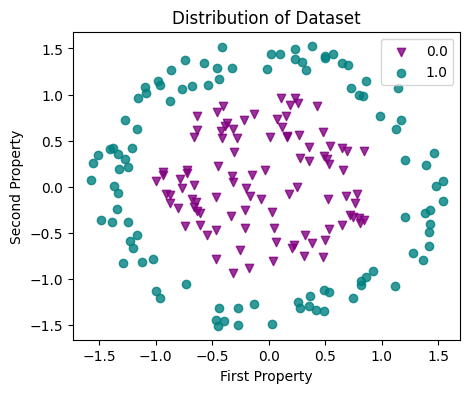

In [5]:
plot_distribution(X, Y)

## Model Training


In [6]:
n_neurons = [3, 4, 8]
models = []

for n in n_neurons:
    print(f"Madaline Model with {n} in hidden layer.")
    model = Madeline(n)
    model.fit(X_train, y_train)
    y_train_pred = model.predict_on(X_train)
    y_test_pred = model.predict_on(X_test)
    models.append(model)

Madaline Model with 3 in hidden layer.


  0%|          | 0/100 [00:00<?, ?it/s]

Madaline Model with 4 in hidden layer.


  0%|          | 0/100 [00:00<?, ?it/s]

Madaline Model with 8 in hidden layer.


  0%|          | 0/100 [00:00<?, ?it/s]

## Analysis of the Results

Madaline Model with 3 in hidden layer.
+---------+----------+
| Dataset | Accuracy |
+---------+----------+
|  Train  |   1.0    |
|  Test   |  0.975   |
+---------+----------+


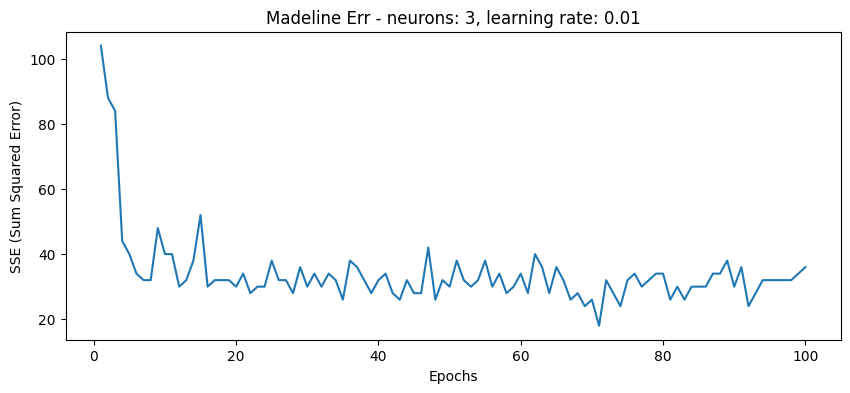

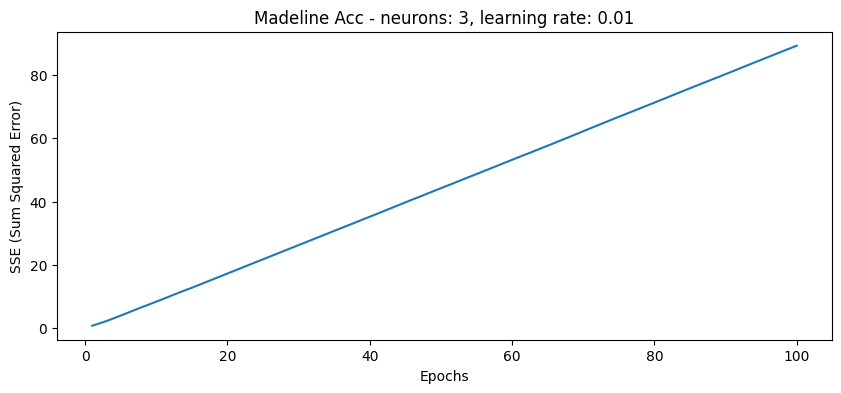

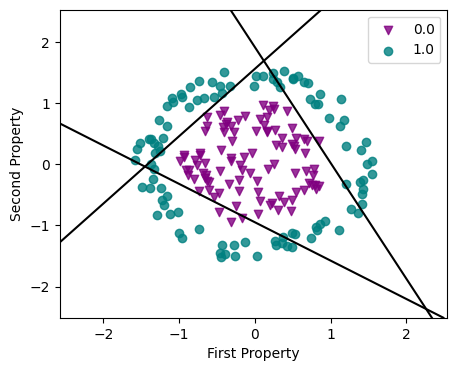

Madaline Model with 4 in hidden layer.
+---------+----------+
| Dataset | Accuracy |
+---------+----------+
|  Train  |   1.0    |
|  Test   |  0.975   |
+---------+----------+


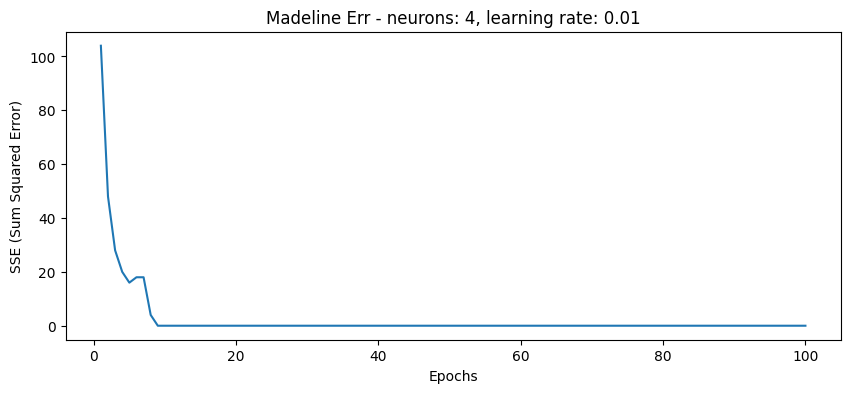

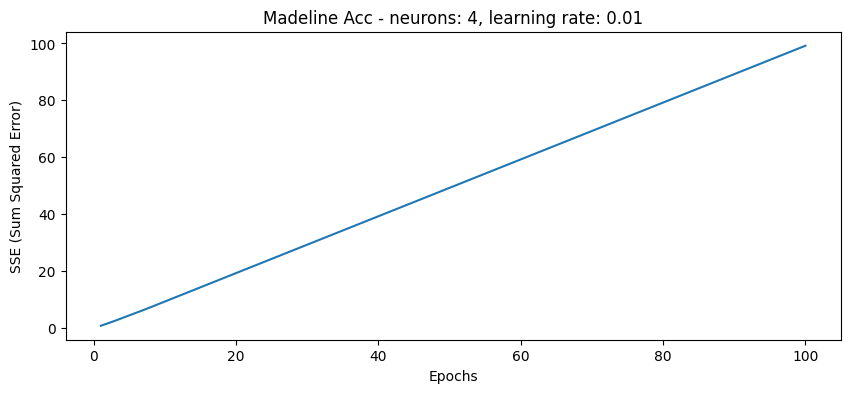

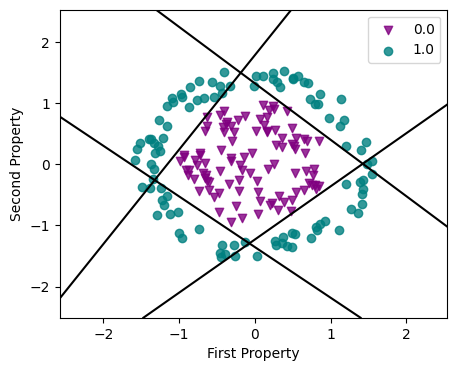

Madaline Model with 8 in hidden layer.
+---------+----------+
| Dataset | Accuracy |
+---------+----------+
|  Train  |   1.0    |
|  Test   |  0.975   |
+---------+----------+


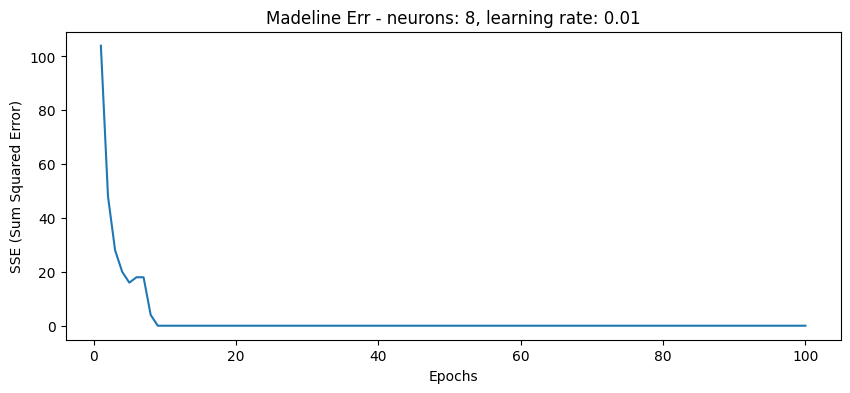

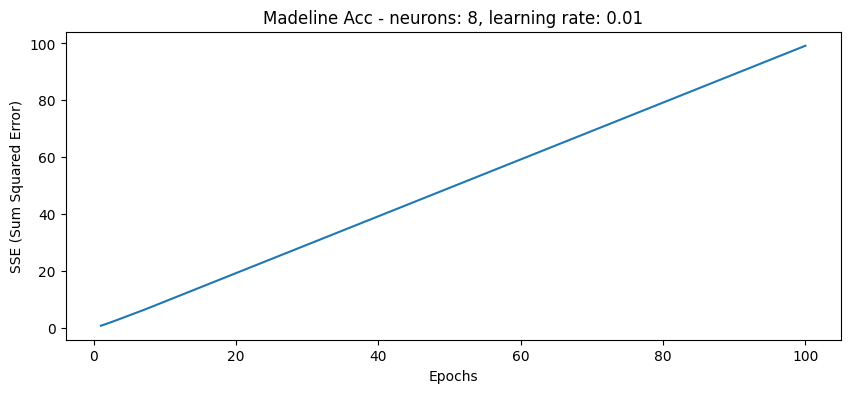

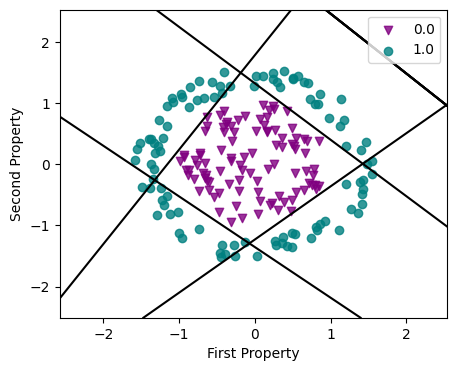

In [7]:
for idx, model in enumerate(models):
    print(f"Madaline Model with {n_neurons[idx]} in hidden layer.")
    log_accuracy(y_train, y_test, y_train_pred, y_test_pred)
    plot_curve(model.loss_per_epoch, f'Madeline Err - neurons: {n_neurons[idx]}, learning rate: {0.01}')
    plot_curve(model.acc_per_epoch, f'Madeline Acc - neurons: {n_neurons[idx]}, learning rate: {0.01}')
    plot_decision_regions(X, Y, model)

## References

- [Ref1]()
- [Ref2]()
- [Ref3]()